# Class Imbalance : Resampling

---

비즈니스 상황에서 타겟 클래스의 불균형은 굉장히 흔한 현상
> * 고객 이탈 예측 : 잔존 > 이탈
* 금융 비정상 거래 예측 : 정상 > 비정상(사기거래)
* 제조 공정간 불량 예측 : 정상 > 불량


* 이번 단원에서는 Class Imbalance 상황에 대해서 살펴보는 것을 중점으로 둡니다.
* 그래서, train과 validation 혹은 test 구분 하지 않고 진행합니다.

## 1.환경 준비

### (1) 라이브러리

In [1]:
# 기본 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification

### (2) 데이터만들기

In [2]:
seed = 28

x, y = make_classification(n_samples=1000,
                        n_features=2,
                        n_redundant=0,
                        weights = [0.95, 0.05],  # class 0과 1의 비율 조정 ==> class imbalance 상황만들기
                        n_clusters_per_class=1,
                        random_state=seed)

### (3) 필요한 함수 만들기

* 데이터 분포 시각화 함수

In [3]:
def my_scatter(x, y) :

    # y가 넘파이 이므로 시리즈로 변환하고 클래스별 갯수 세기
    temp = pd.Series(y).value_counts()

    plt.figure(figsize=(6, 6))
    plt.title(f'0 : {temp[0]},    1 : {temp[1]}')

    sns.scatterplot(x=x[:,0], y=x[:,1], hue=y)

    plt.xlabel('x1')
    plt.ylabel('x2')
    # plt.xlim(-4, 2.2)
    # plt.ylim(-4, 2.2)
    plt.show()

* svm 모델 시각화
    * 아래 모델은 x의 **feauture 수가 2개일 때만 가능**합니다.
    * 모델 두개를 비교 가능.

** [Numpy] 1차원 변환 ravel() vs. reshape() vs. flatten()
** https://m.blog.naver.com/wideeyed/221533365486

In [4]:
def svm_visualize(x, y, model1, model2 = 0) :

    xx, yy = np.meshgrid(np.linspace(x[:,0].min(), x[:,0].max(), 50),
                         np.linspace(x[:,1].min(), x[:,1].max(), 50)) # mesh grid

    # 메쉬 그리드값에 대해 모델 부터 거리 값 만들기.
    Z = model1.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    if model2 != 0 : # 두번째 모델이 있으면 처리
        Z1 = model2.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z1 = Z1.reshape(xx.shape)

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=x[:,0], y=x[:,1], hue=y)
    plt.contour(xx, yy, Z, levels=[0], colors = 'gray',linestyles  = '--')

    if model2 != 0 : # 두번째 모델이 있으면 처리
        plt.contour(xx, yy, Z1, levels=[0], colors = 'r',linestyles  = '--')

    plt.axis("tight")
    plt.show()

- 위에서 만든 데이터 분포를 확인합니다.

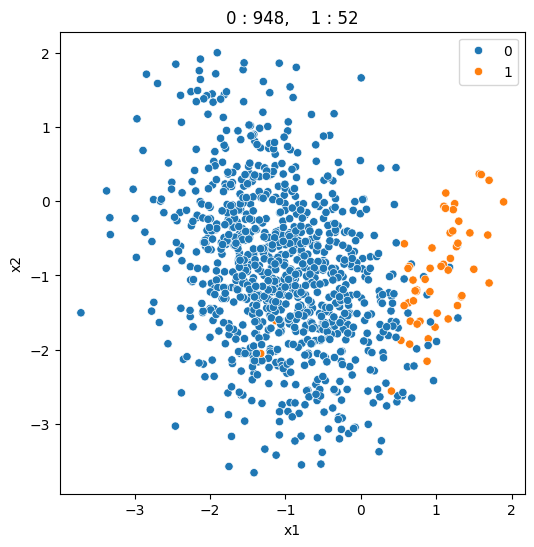

In [5]:
my_scatter(x, y)

## 2.불균형 데이터 그대로 사용하기

### (1) 데이터 둘러보기

0    948
1     52
Name: count, dtype: int64


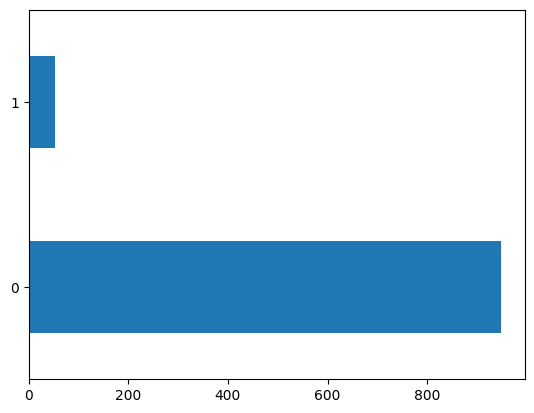

In [6]:
# class imbalance
print(pd.Series(y).value_counts())

pd.Series(y).value_counts().plot(kind = 'barh')
plt.show()

### (2) 그대로 모델링 수행

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import *

In [8]:
# 모델링 및 평가
model = SVC(kernel='linear')
model.fit(x, y)
pred = model.predict(x)

print(confusion_matrix(y, pred))
print('=' * 55)
print(classification_report(y, pred))
#940개는 예측해서 잘 맞춤
#33개는 비정상을 잘 맞춤
#다만 예측했는데 불량, 불량인데 예측 못함이 있음

[[940   8]
 [ 19  33]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       948
           1       0.80      0.63      0.71        52

    accuracy                           0.97      1000
   macro avg       0.89      0.81      0.85      1000
weighted avg       0.97      0.97      0.97      1000



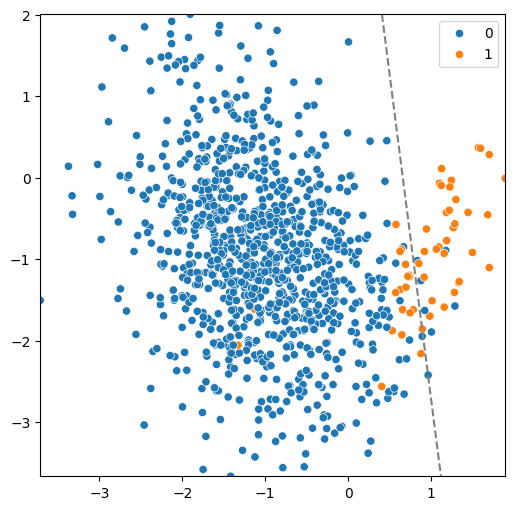

In [9]:
svm_visualize(x,y, model)

## 3.Resampling & 모델링

In [10]:
# !pip install imblearn

In [11]:
# 필요한 함수들을 불러옵니다.
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

### (1) Down sampling

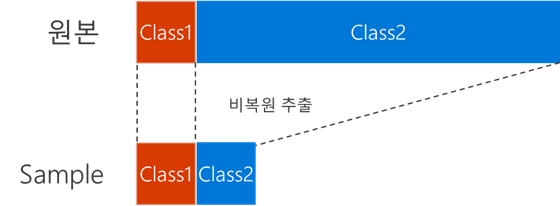

* Down Sampling을 수행하고 데이터 분포를 비교해 봅시다.

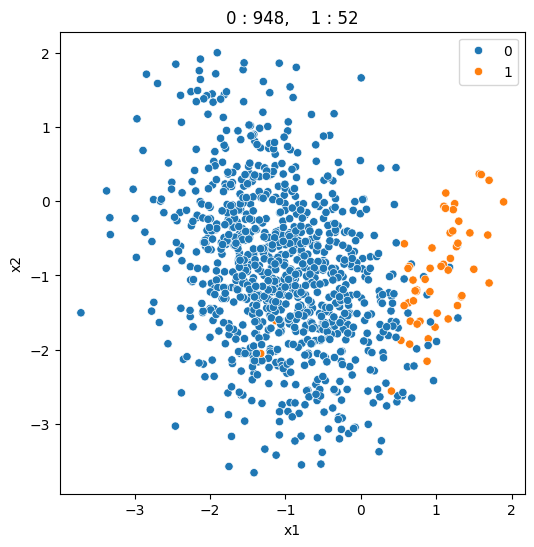

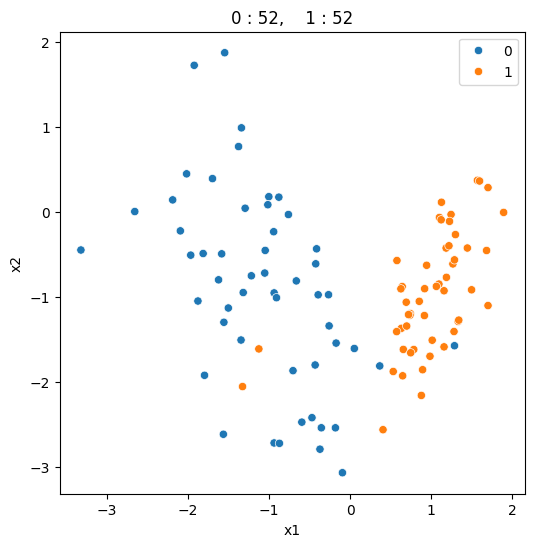

In [12]:
# Down sampling : 적은 쪽 클래스는 그대로, 많은 쪽 클래스는 랜덤 샘플링(적은쪽 클래수 수 만큼)
rus = RandomUnderSampler(random_state = 4)
x_d, y_d = rus.fit_resample(x, y)

my_scatter(x, y)
my_scatter(x_d, y_d)

* Down Sampling 데이터셋으로 학습하고 모델을 시각화 해 봅시다.

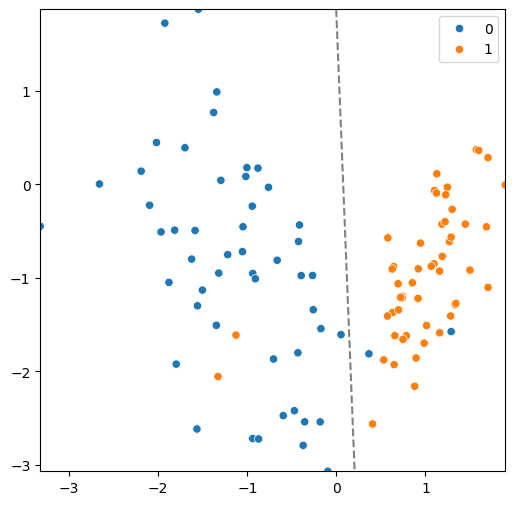

In [13]:
model_d = SVC(kernel='linear')
model_d.fit(x_d,y_d)

svm_visualize(x_d,y_d, model_d)

* 기존 모델과 비교해 봅시다.

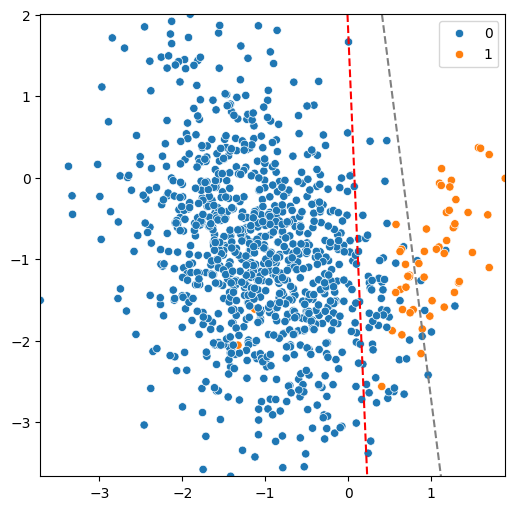

In [14]:
svm_visualize(x,y, model, model_d)

* 기존 데이터를 가지고 예측하고 평가해 봅시다.

In [15]:
# 모델링 및 평가
pred = model_d.predict(x)

print(confusion_matrix(y, pred))
print('=' * 60)
print(classification_report(y, pred))

# 기존보다 더 잘 학습하는 듯?

[[888  60]
 [  2  50]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       948
           1       0.45      0.96      0.62        52

    accuracy                           0.94      1000
   macro avg       0.73      0.95      0.79      1000
weighted avg       0.97      0.94      0.95      1000



### (2) Up sampling

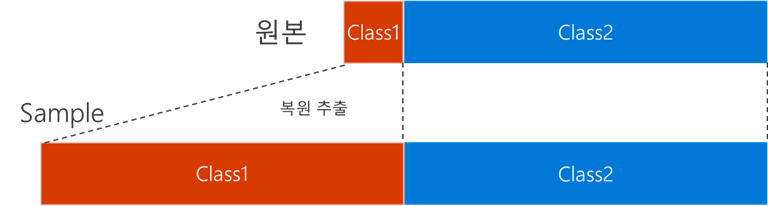

* Up Sampling을 수행하고 데이터 분포를 비교해 봅시다.

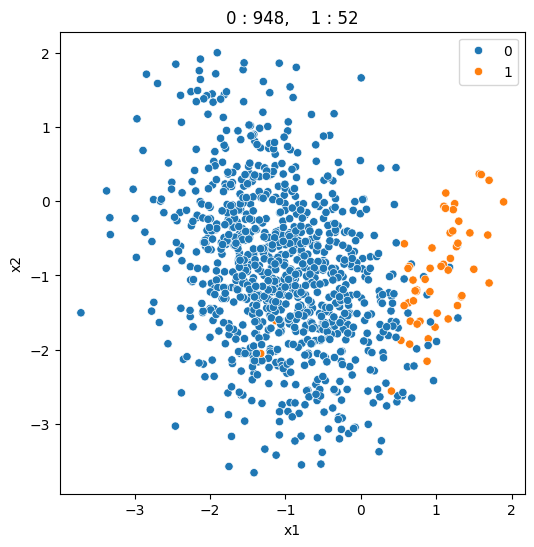

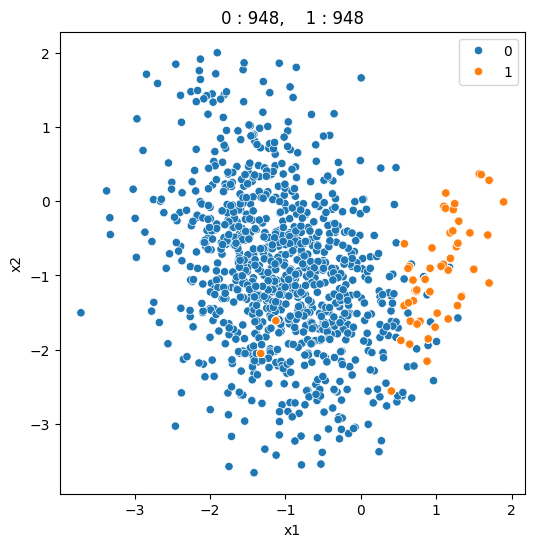

In [16]:
# Up sampling : 많은 클래스는 그대로, 적은 클래스는 랜덤 복원추출(많은 클래스 만큼)
ros = RandomOverSampler(random_state = 4)
x_u, y_u = ros.fit_resample(x, y)

my_scatter(x, y)
my_scatter(x_u, y_u)

In [17]:
# 데이터를 열어보면, 클래스 1의 값이 중복으로 추출된 것을 볼수 있습니다.
UpSample = pd.DataFrame(x_u, columns=['x1','x2'])
UpSample['y'] = y_u
UpSample.loc[UpSample['y'] == 1].sort_values('x1')

,x1,x2,y
1016,-1.328629,-2.054089,1
1493,-1.328629,-2.054089,1
1675,-1.328629,-2.054089,1
1635,-1.328629,-2.054089,1
1034,-1.328629,-2.054089,1
...,...,...,...
1289,1.895357,-0.006780,1
420,1.895357,-0.006780,1
1453,1.895357,-0.006780,1
1258,1.895357,-0.006780,1


In [18]:
# 랜덤 복원 추출을 하다보니, 모든 값이 동일한 수 만큼 추출된 것이 아니라, 각각 다르게 추출됨
UpSample.loc[UpSample['y'] == 1].value_counts()

x1         x2         y
 0.894752  -1.855946  1    28
 0.785587  -1.618389  1    25
 0.697953  -1.342480  1    24
 0.574446  -1.407863  1    24
 1.571462   0.370428  1    23
 1.499472  -0.916432  1    23
 1.096105  -0.849348  1    23
 0.405838  -2.561105  1    23
 0.879246  -2.158189  1    22
 0.643148  -0.878539  1    22
 1.226977  -0.111816  1    22
 1.895357  -0.006780  1    22
 1.333153  -1.287846  1    21
 1.282513  -1.406968  1    21
 1.288207  -0.564498  1    21
 0.626623  -0.904875  1    20
 1.702421  -1.101668  1    20
 1.127556   0.112743  1    20
 0.985638  -1.697665  1    19
 0.853566  -1.051973  1    19
 1.159467  -1.587275  1    19
 1.188926  -0.770098  1    19
 1.598135   0.362476  1    19
-1.328629  -2.054089  1    18
 1.245931  -0.031008  1    18
 1.447459  -0.425332  1    18
 1.300197  -0.267356  1    18
 0.919813  -0.903274  1    18
 0.577839  -0.572423  1    17
 0.648435  -1.927372  1    17
-1.127272  -1.611335  1    17
 1.064690  -0.876420  1    17
 1.159401  -0.92

* UP Sampling 데이터셋으로 학습하고 모델을 시각화 해 봅시다.

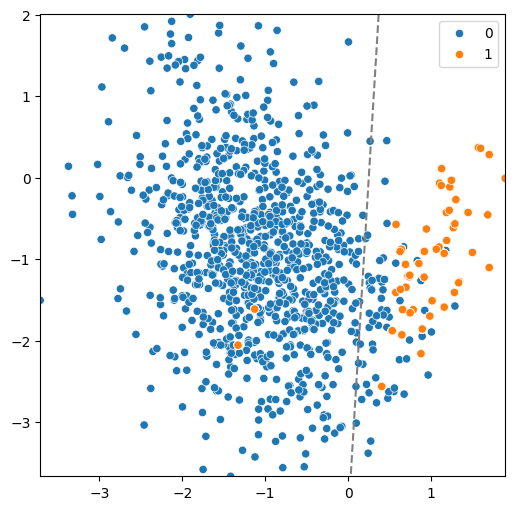

In [19]:
model_u = SVC(kernel='linear')
model_u.fit(x_u,y_u)

svm_visualize(x_u,y_u, model_u)

* 기존 모델과 비교해 봅시다.

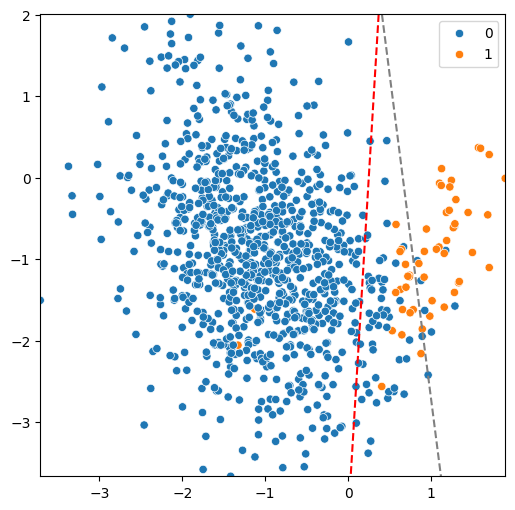

In [20]:
svm_visualize(x,y, model, model_u)

* 기존 데이터를 가지고 예측하고 평가해 봅시다.

In [21]:
# 모델링 및 평가
pred = model_u.predict(x)

print(confusion_matrix(y, pred))
print('=' * 60)
print(classification_report(y, pred))

[[888  60]
 [  2  50]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       948
           1       0.45      0.96      0.62        52

    accuracy                           0.94      1000
   macro avg       0.73      0.95      0.79      1000
weighted avg       0.97      0.94      0.95      1000



### (3) SMOTE(**S**ynthetic **M**inority **O**versampling **TE**chnique)

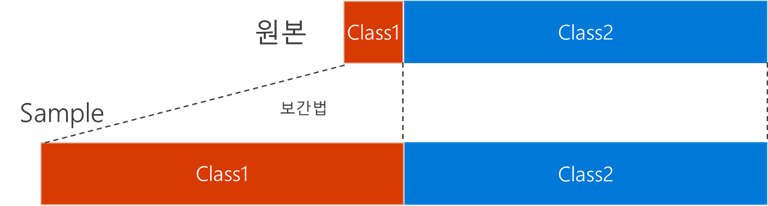

* SMOTE Sampling을 수행하고 데이터 분포를 비교해 봅시다.

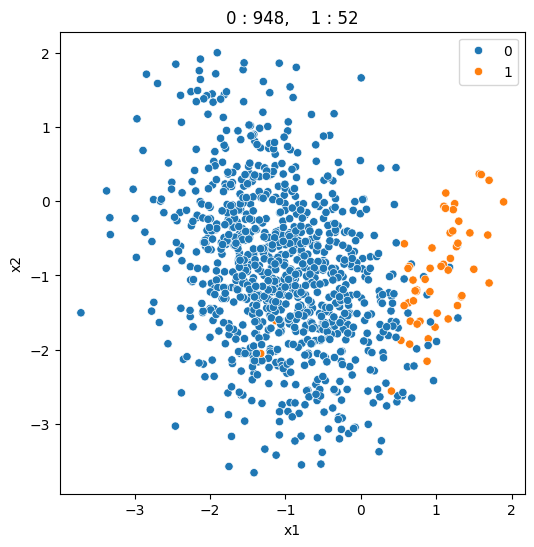

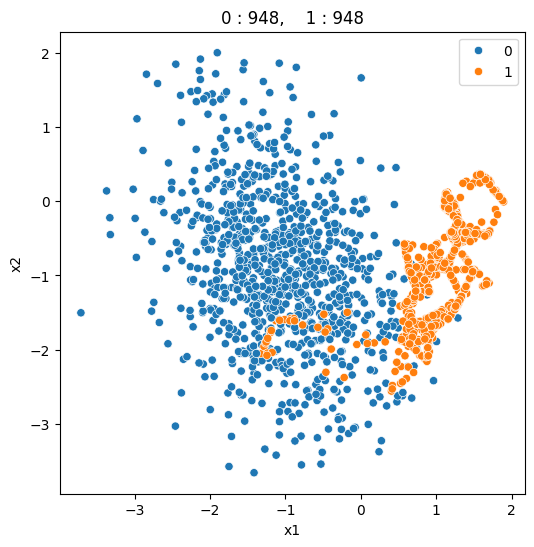

In [22]:
# SMOTE : 많은쪽은 그대로(혹은 약간 down sampling), 적은쪽은 보간법!
smote = SMOTE(random_state = 4) # k_neighbors의미 확인
x_sm, y_sm = smote.fit_resample(x, y)

my_scatter(x, y)
my_scatter(x_sm, y_sm)

In [23]:
# 데이터를 열어보면 값들이 보간법으로 생성된 것을 볼수 있다.
SMOTESample = pd.DataFrame(x_sm.copy(), columns=['x1','x2'])
SMOTESample['y'] = y_sm
SMOTESample.loc[SMOTESample['y'] == 1].sort_values('x1')

,x1,x2,y
778,-1.328629,-2.054089,1
1030,-1.285328,-1.958878,1
1158,-1.264018,-1.912021,1
1474,-1.257227,-1.897089,1
1339,-1.252486,-1.886662,1
...,...,...,...
1003,1.854019,0.055761,1
1314,1.865662,0.038147,1
1369,1.868617,0.026440,1
1378,1.884133,0.010201,1


* SMOTE Sampling 데이터셋으로 학습하고 모델을 시각화 해 봅시다.

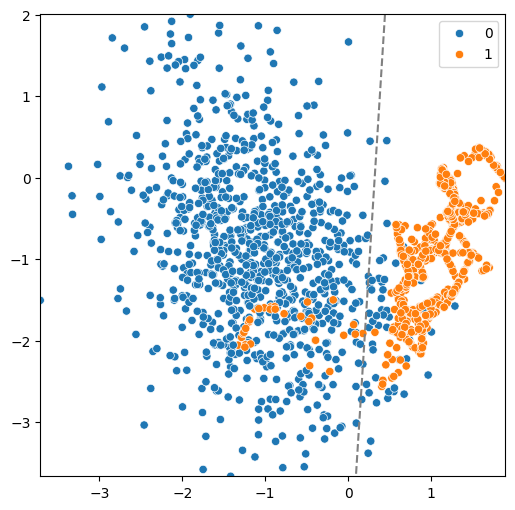

In [24]:
model_sm = SVC(kernel='linear')
model_sm.fit(x_sm,y_sm)

svm_visualize(x_sm,y_sm, model_sm)

* 기존 모델과 비교해 봅시다.

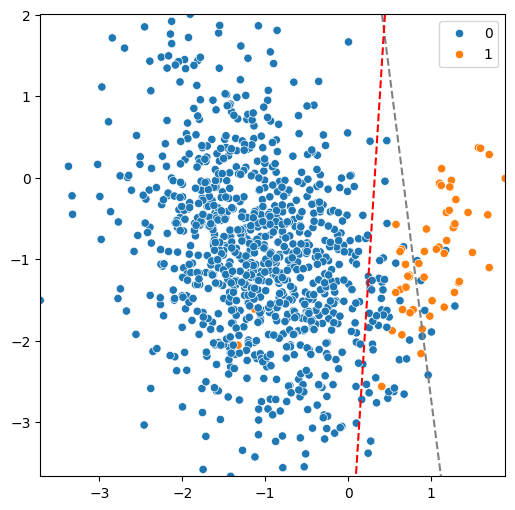

In [25]:
svm_visualize(x,y, model, model_sm)

* 기존 데이터를 가지고 예측하고 평가해 봅시다.

In [26]:
# 모델링 및 평가
pred = model_sm.predict(x)

print(confusion_matrix(y, pred))
print('=' * 60)
print(classification_report(y, pred))

[[895  53]
 [  2  50]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       948
           1       0.49      0.96      0.65        52

    accuracy                           0.94      1000
   macro avg       0.74      0.95      0.81      1000
weighted avg       0.97      0.94      0.95      1000



## 4.예제 : Semiconductor manufacturing process dataset


![](https://assets.pandaily.com/uploads/2021/10/semiconductor.png)

* 반도체 제조 공정은 시점별로 수많은 센서로부터 정보를 수집하여 공정을 감시합니다.
* 센서정보와 함께 공정간 발생된 불량품에 대한 정보를 저장하였습니다.
* 불량을 예측해 봅시다.

### (1) 데이터 준비

* 데이터 로딩

In [27]:
path = "secom_9.csv"
data = pd.read_csv(path)

data['label'] = 0
data.loc[data['defeat']== 'defeat', 'label']= 1
data.drop(['datetime','defeat'], axis = 1, inplace=True)
data.head()

,v021,v087,v088,v089,v114,v115,v116,v117,v118,v120,...,v528,v571,v572,v573,v574,v575,v576,v577,v578,label
0,1.4026,2.3895,0.9690,1747.6049,0.9460,0.0,748.6115,0.9908,58.4306,0.9804,...,6.6926,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,0
1,1.3825,2.3754,0.9894,1931.6464,0.9425,0.0,731.2517,0.9902,58.6680,0.9731,...,8.8370,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0
2,1.4123,2.4532,0.9880,1685.8514,0.9231,0.0,718.5777,0.9899,58.4808,0.9772,...,6.4568,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,1
3,1.4011,2.4004,0.9904,1752.0968,0.9564,0.0,709.0867,0.9906,58.6635,0.9761,...,6.4865,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0
4,1.3888,2.4530,0.9902,1828.3846,0.9424,0.0,796.5950,0.9908,58.3858,0.9628,...,6.3745,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,0


변수 정보
* label : 1 - 불량, 0 - 정상
* v### : 센서값들


In [28]:
target = 'label'

In [29]:
data[target].value_counts() / data.shape[0]

label
0    0.933631
1    0.066369
Name: count, dtype: float64

* x, y로 나누기

In [30]:
x = data.drop(target, axis = 1)
y = data.loc[:, target]

* 가변수화 Dummy Variable  
모두 숫자 데이터이므로 가변수화 대상은 없습니다.


* 데이터 분할
    * 이미 test set은 분할되어 있다고 가정합니다.
    * 주어진 데이터를 train set : validation set 으로 분할

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 2022)

In [33]:
print(x_train.shape, x_val.shape)

(1253, 52) (314, 52)


### (2) 기본모델링
> * 알고리즘은 로지스틱 회귀를 이용합시다.
* 데이터셋을 그대로 모델링을 수행하시오.
* validate set으로 예측하고 평가(classification report, f1 score)해 봅시다.


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

In [35]:
model = LogisticRegression(solver = 'liblinear')
# model = SVC(kernel='linear')
# model.fit(x, y)
# pred = model.predict(x)

# print(confusion_matrix(y, pred))
# print('=' * 55)
# print(classification_report(y, pred))
# 모델학습
model.fit(x_train, y_train)
# 모델예측
pred = model.predict(x_val)

print(confusion_matrix(y_val, pred))
print('-' * 55)
print(classification_report(y_val, pred))

[[295   1]
 [ 18   0]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       296
           1       0.00      0.00      0.00        18

    accuracy                           0.94       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.89      0.94      0.91       314



### (3) 모델링 with Resampling
> * down, up, smote 샘플링후 각각 데이터를 이용하여 모델링 하시오.
* 알고리즘 : 기존 샘플과 비교를 위해서 기본모델링에 사용한 알고리즘 사용
* validate set으로 예측하고 평가(classification report, f1 score)해 봅시다.


In [36]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [37]:
# down sampling
rus = RandomUnderSampler(random_state = 4)
x_d, y_d = rus.fit_resample(x_train, y_train)
model_d = LogisticRegression(solver = 'liblinear')
model_d.fit(x_d, y_d)
# 모델예측
pred_d = model_d.predict(x_val)
down_sample = RandomUnderSampler(random_state=4)
d_x_train, d_y_train = rus.fit_resample(x_train, y_train)

In [38]:
# up sampling
ros = RandomOverSampler(random_state = 4)
x_u, y_u = ros.fit_resample(x_train, y_train)
model_u = LogisticRegression(solver = 'liblinear')
model_u.fit(x_u, y_u)
# 모델예측
pred_u = model_u.predict(x_val)
up_sample = RandomOverSampler(random_state=4)
u_x_train, u_y_train = ros.fit_resample(x_train, y_train)

In [39]:
# SMOTE
smote = SMOTE(random_state = 4) # k_neighbors의미 확인
x_sm, y_sm = smote.fit_resample(x_train, y_train)
model_s = LogisticRegression(solver = 'liblinear')
model_s.fit(x_sm, y_sm)
# 모델예측
pred_s = model_s.predict(x_val)
smote = SMOTE(random_state=4)
s_x_train, s_y_train = smote.fit_resample(x_train, y_train)


* 모델링

In [40]:
#코드를 작성하시오

print(f1_score(y_val,pred_d, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_d))
print('-' * 55)
print(classification_report(y_val, pred_d))

0.1125
-------------------------------------------------------
[[163 133]
 [  9   9]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.55      0.70       296
           1       0.06      0.50      0.11        18

    accuracy                           0.55       314
   macro avg       0.51      0.53      0.40       314
weighted avg       0.90      0.55      0.66       314



In [41]:
#코드를 작성하시오

print(f1_score(y_val,pred_u, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_u))
print('-' * 55)
print(classification_report(y_val, pred_u))

0.1388888888888889
-------------------------------------------------------
[[180 116]
 [  8  10]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.61      0.74       296
           1       0.08      0.56      0.14        18

    accuracy                           0.61       314
   macro avg       0.52      0.58      0.44       314
weighted avg       0.91      0.61      0.71       314



In [42]:
#코드를 작성하시오
# x_sm_array = x_sm.values if isinstance(x_sm, pd.DataFrame) else x_sm
# y_sm_array = y_sm.values if isinstance(y_sm, pd.Series) else y_sm

# svm_visualize(x_sm_array, y_sm_array, model, model_s)
print(f1_score(y_val,pred_s, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_s))
print('-' * 55)
print(classification_report(y_val, pred_s))

0.13138686131386862
-------------------------------------------------------
[[186 110]
 [  9   9]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.63      0.76       296
           1       0.08      0.50      0.13        18

    accuracy                           0.62       314
   macro avg       0.51      0.56      0.44       314
weighted avg       0.90      0.62      0.72       314



### (4) [추가] 로지스틱 회귀 - 여러번 반복 실행

* 다음 절차를 반복적으로 수행한 후 결과를 저장합시다.
    * train_test_split
    * down sampling, up sampling ,smote 로 각각 데이터 저장
    * 각각의 샘플을 이용하여 로지스틱 회귀 모델 생성
    * 각 모델의 예측 및 f1 score 결과를 저장(down, up, smote 샘플로 만든 모델의 예측 결과를 각각의 리스트 등에 저장)
* 반복 수행 후 저장된 f1 score를 density plot(sns.kdeplot() 등) 으로 그래프로 그려 비교해 봅시다.

In [43]:
def lr_modeling(x_train, y_train, x_val, y_val) :
    m = LogisticRegression(solver = 'liblinear')
    m.fit(x_train, y_train)
    pred = m.predict(x_val)
    return f1_score(y_val,pred, pos_label=1)

In [44]:
result_d, result_u, result_s = [], [], []

for i in range(50):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .4)
    d_x_train, d_y_train = down_sample.fit_resample(x_train, y_train)
    u_x_train, u_y_train = up_sample.fit_resample(x_train, y_train)
    s_x_train, s_y_train = smote.fit_resample(x_train, y_train)

    result_d.append(lr_modeling(d_x_train, d_y_train, x_val, y_val))
    result_u.append(lr_modeling(u_x_train, u_y_train, x_val, y_val))
    result_s.append(lr_modeling(s_x_train, s_y_train, x_val, y_val))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


/home/clip968/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/clip968/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


47
48
49


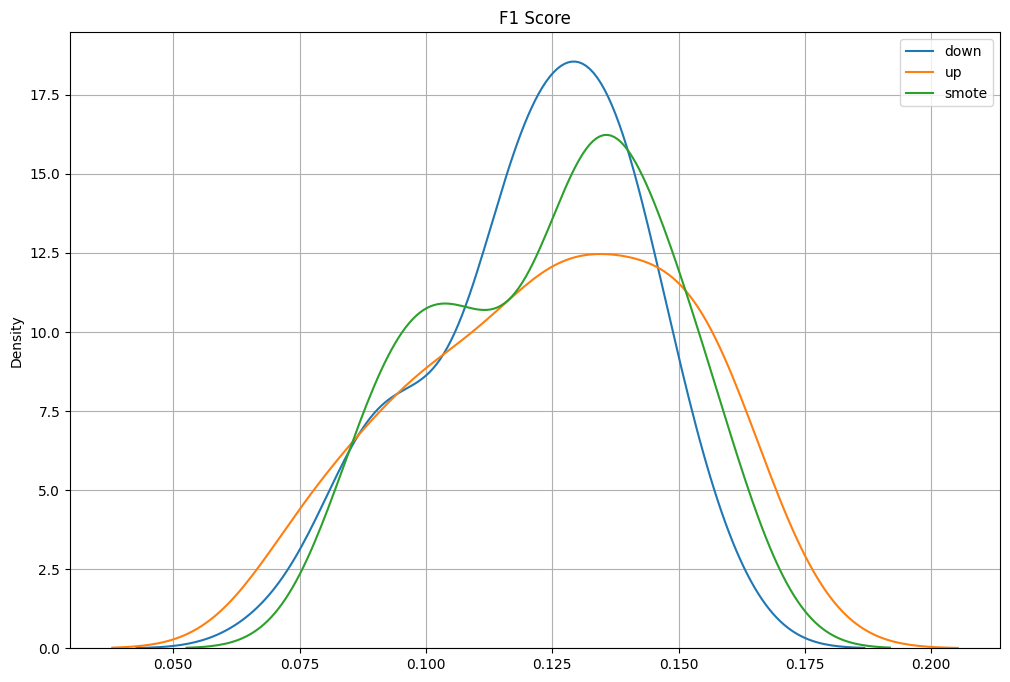

In [45]:
# 그래프로 비교
plt.figure(figsize=(12, 8))
sns.kdeplot(result_d, label= 'down')
sns.kdeplot(result_u, label = 'up')
sns.kdeplot(result_s, label = 'smote' )

plt.title('F1 Score')
plt.legend()
plt.grid()
plt.show()

## 5.실습 : 고객이탈 예측 - Resampling

### (1) 데이터 준비

* 데이터 로딩

In [46]:
path = "mobile_class_imbalance.csv"
data = pd.read_csv(path)

target = 'CHURN'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

* 데이터 탐색

In [47]:
data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN
0,1,145297,71,37,969515,478,4,1,avg,very_little,no,0
1,0,115956,0,11,899704,710,0,5,unsat,very_high,actively_looking_into_it,0
2,0,40683,212,15,844664,188,24,5,very_unsat,very_little,no,0
3,1,33043,0,81,539732,162,1,1,unsat,very_little,never_thought,0
4,1,50743,0,22,430005,318,16,5,unsat,very_high,actively_looking_into_it,0


In [48]:
y.value_counts()

CHURN
0    10148
1      300
Name: count, dtype: int64

In [49]:
y.value_counts() / y.shape[0]

CHURN
0    0.971286
1    0.028714
Name: count, dtype: float64

* 가변수화

In [50]:
cat = ['REPORTED_SATISFACTION','REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']

for v in cat :
    dumm = pd.get_dummies(x[v], prefix=v, drop_first=True)
    x = pd.concat([x, dumm], axis=1)
    x.drop(v, axis=1, inplace = True)

* 데이터 분할

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 2000, random_state=2021)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 2000, random_state=2021)

### (2)기본모델링
> * 데이터셋을 그대로 모델링을 수행하시오.
* 알고리즘 : 로지스틱회귀, SVM 중 하나 사용.
* validate set으로 예측하고 평가(classification report, f1 score)해 봅시다.


In [52]:
model = LogisticRegression(solver = 'liblinear')
model.fit(x_train, y_train)
# 모델예측
pred = model.predict(x_val)
print(confusion_matrix(y_val, pred))
print('-' * 55)
print(classification_report(y_val, pred))

[[1949    0]
 [  51    0]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1949
           1       0.00      0.00      0.00        51

    accuracy                           0.97      2000
   macro avg       0.49      0.50      0.49      2000
weighted avg       0.95      0.97      0.96      2000



/home/clip968/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/clip968/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/clip968/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

### (3)모델링 with Resampling
> * down, up, smote 샘플링후 각각 데이터를 이용하여 모델링 하시오.
* 알고리즘 : 기존 샘플과 비교를 위해서 기본모델링에 사용한 알고리즘 사용
* validate set으로 예측하고 평가(classification report, f1 score)해 봅시다.


In [53]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [55]:
# down sampling
rus = RandomUnderSampler(random_state = 4)
x_d, y_d = rus.fit_resample(x_train, y_train)
model_d = LogisticRegression(solver = 'liblinear')
model_d.fit(x_d, y_d)
# 모델예측
pred_d = model_d.predict(x_val)
down_sample = RandomUnderSampler(random_state=4)
d_x_train, d_y_train = rus.fit_resample(x_train, y_train)

In [56]:
# up sampling
ros = RandomOverSampler(random_state = 4)
x_u, y_u = ros.fit_resample(x_train, y_train)
model_u = LogisticRegression(solver = 'liblinear')
model_u.fit(x_u, y_u)
# 모델예측
pred_u = model_u.predict(x_val)
up_sample = RandomOverSampler(random_state=4)
u_x_train, u_y_train = ros.fit_resample(x_train, y_train)

In [57]:
# SMOTE
smote = SMOTE(random_state = 4) # k_neighbors의미 확인
x_sm, y_sm = smote.fit_resample(x_train, y_train)
model_s = LogisticRegression(solver = 'liblinear')
model_s.fit(x_sm, y_sm)
# 모델예측
pred_s = model_s.predict(x_val)
smote = SMOTE(random_state=4)
s_x_train, s_y_train = smote.fit_resample(x_train, y_train)


* 모델링

In [58]:
#코드를 작성하시오

print(f1_score(y_val,pred_d, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_d))
print('-' * 55)
print(classification_report(y_val, pred_d))

0.07604562737642585
-------------------------------------------------------
[[1241  708]
 [  21   30]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.64      0.77      1949
           1       0.04      0.59      0.08        51

    accuracy                           0.64      2000
   macro avg       0.51      0.61      0.42      2000
weighted avg       0.96      0.64      0.76      2000



In [59]:
#코드를 작성하시오

print(f1_score(y_val,pred_u, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_u))
print('-' * 55)
print(classification_report(y_val, pred_u))

0.07662835249042145
-------------------------------------------------------
[[1247  702]
 [  21   30]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.64      0.78      1949
           1       0.04      0.59      0.08        51

    accuracy                           0.64      2000
   macro avg       0.51      0.61      0.43      2000
weighted avg       0.96      0.64      0.76      2000



In [60]:
#코드를 작성하시오
print(f1_score(y_val,pred_s, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_s))
print('-' * 55)
print(classification_report(y_val, pred_s))

0.07692307692307693
-------------------------------------------------------
[[1275  674]
 [  22   29]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.65      0.79      1949
           1       0.04      0.57      0.08        51

    accuracy                           0.65      2000
   macro avg       0.51      0.61      0.43      2000
weighted avg       0.96      0.65      0.77      2000



* 모델링 여러번 반복 실행

In [62]:
def lr_modeling(x_train, y_train, x_val, y_val) :
    m = LogisticRegression(solver = 'liblinear')
    m.fit(x_train, y_train)
    pred = m.predict(x_val)
    return f1_score(y_val,pred, pos_label=1)

In [63]:
result_d, result_u, result_s = [], [], []

for i in range(50):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .4)
    d_x_train, d_y_train = down_sample.fit_resample(x_train, y_train)
    u_x_train, u_y_train = up_sample.fit_resample(x_train, y_train)
    s_x_train, s_y_train = smote.fit_resample(x_train, y_train)

    result_d.append(lr_modeling(d_x_train, d_y_train, x_val, y_val))
    result_u.append(lr_modeling(u_x_train, u_y_train, x_val, y_val))
    result_s.append(lr_modeling(s_x_train, s_y_train, x_val, y_val))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


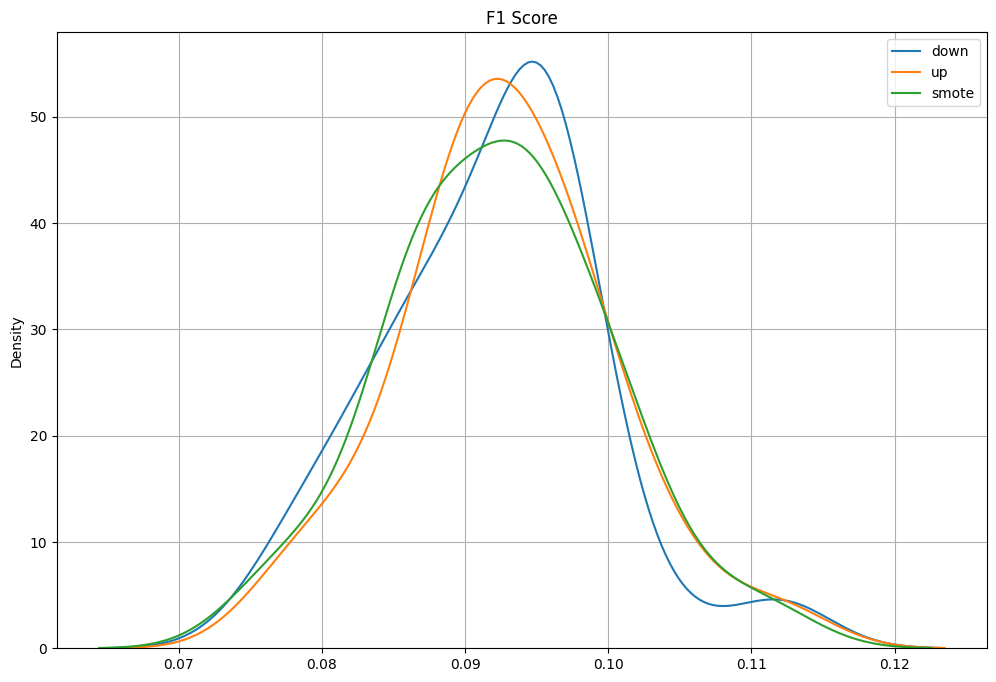

In [64]:
# 그래프로 비교
plt.figure(figsize=(12, 8))
sns.kdeplot(result_d, label= 'down')
sns.kdeplot(result_u, label = 'up')
sns.kdeplot(result_s, label = 'smote' )

plt.title('F1 Score')
plt.legend()
plt.grid()
plt.show()